In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cmocean as cm
from collections import OrderedDict
import cftime
import glob

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

In [2]:
#client = Client(n_workers=4)
# >> dask-scheduler
# >> dask-worker tcp://10.0.64.9:8786 --memory-limit 4e9 --nprocs 6 --nthreads 1 --local-directory /local/g40/amh157
#client = Client('tcp://10.0.64.9:8786', local_dir='/local/g40/amh157')
client = Client(n_workers=16)
client

Client Scheduler: tcp://127.0.0.1:36865 Dashboard: /proxy/36195/status,Cluster Workers: 16 Cores: 16 Memory: 17.18 GB


In [3]:
db = '/scratch/e14/rmh561/access-om2/archive/databases/cc_database_omip'
session = cc.database.create_session(db)

In [4]:
exptdict = OrderedDict([
    ('025 OMIP2 cycle 1',   {'expt':'025deg_jra55_iaf_cycle1'}),
    ('025 OMIP2 cycle 1 oldtopo',  {'expt':'025deg_jra55_iaf_newIC'}),
    ('025 OMIP2 cycle 2',   {'expt':'025deg_jra55_iaf_cycle2'}),
    ('1 OMIP2 cycle 1',  {'expt':'1deg_jra55_iaf_omip2'}),
    ('1 OMIP2 cycle 2',  {'expt':'1deg_jra55_iaf_omip2_cycle2'}),
    ('025 RYF',   {'expt':'025deg_jra55_ryf9091_gadi'}),
])

## Just checking the final data for each expt.

In [5]:
for ekey in exptdict.keys():
    variable = 'temp_global_ave'
    expt = exptdict[ekey]['expt']
    var = cc.querying.getvar(expt,variable,session,ncfile='ocean_scalar.nc')
    start_year = np.int(np.ceil(cftime.date2num(var['time'].min(),'days since 0001-01-01','noleap')/365))
    end_year = np.int(np.ceil(cftime.date2num(var['time'].max(),'days since 0001-01-01','noleap')/365))
    print(expt+' goes from %d to %d'% (start_year, end_year))
    
end_time = '2019-01-01'
print(' Setting end_time to',end_time)

025deg_jra55_iaf_cycle1 goes from 1958 to 2018
025deg_jra55_iaf_newIC goes from 1958 to 2017
025deg_jra55_iaf_cycle2 goes from 1958 to 1985
1deg_jra55_iaf_omip2 goes from 1958 to 2018
1deg_jra55_iaf_omip2_cycle2 goes from 1958 to 2018
025deg_jra55_ryf9091_gadi goes from 1900 to 2499
 Setting end_time to 2019-01-01


## Scalar diagnostics

In [9]:
def plot_timeseries(variable,end_time,ncfile=None):
    plt.figure(figsize=(10,5))
    for ekey in exptdict.keys():
        expt = exptdict[ekey]['expt']
        var = cc.querying.getvar(expt,variable,session,end_time=end_time,ncfile=ncfile)
        var.resample(time='Y').mean().plot(label=ekey)
    plt.title(variable)
    plt.legend()
    return

### Global Average Temperature

CPU times: user 8.29 s, sys: 205 ms, total: 8.49 s
Wall time: 10.3 s


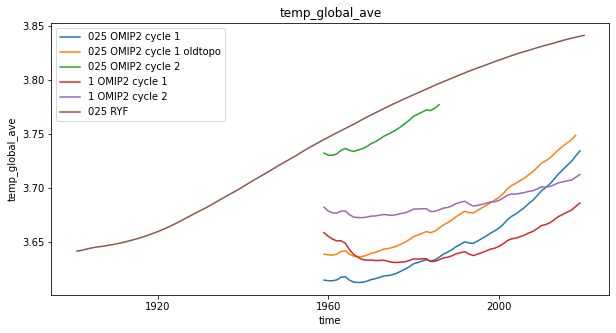

In [10]:
%%time
plot_timeseries('temp_global_ave',end_time,ncfile='ocean_scalar.nc')

### Global Average Salinity

CPU times: user 8.16 s, sys: 164 ms, total: 8.33 s
Wall time: 9.89 s


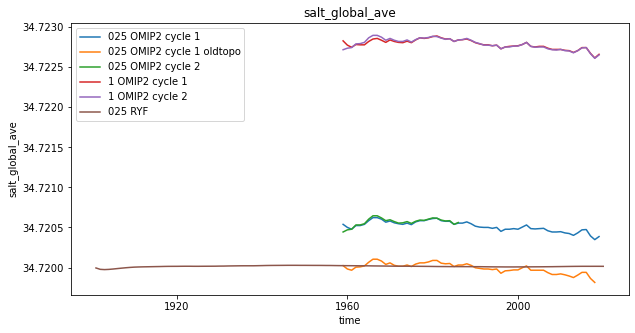

In [11]:
%%time
plot_timeseries('salt_global_ave',end_time,ncfile='ocean_scalar.nc')

### Surface Temperature

VariableNotFoundError: No files were found containing 'temp_surface_ave' in the '025deg_jra55_ryf9091_gadi' experiment

<Figure size 720x360 with 0 Axes>

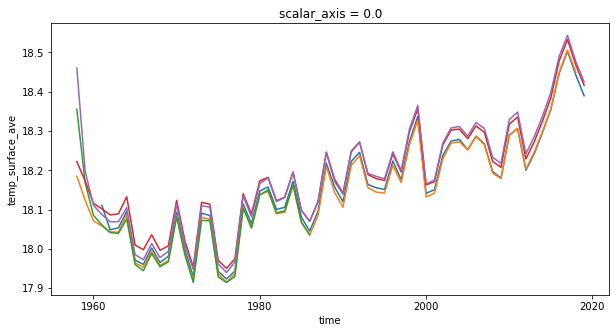

In [13]:
%%time
try:
    plot_timeseries('temp_surface_ave',end_time,ncfile='ocean_scalar.nc')
except:
    plot_timeseries('temp_surface_ave',end_time,ncfile='ocean_scalar_snapshot.nc')

### Surface Salinity

CPU times: user 8.16 s, sys: 179 ms, total: 8.34 s
Wall time: 9.78 s


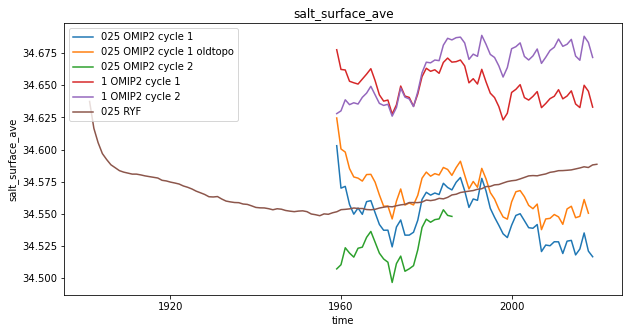

In [14]:
%%time
plot_timeseries('salt_surface_ave',end_time,ncfile='ocean_scalar.nc')

### Total Kinetic Energy

CPU times: user 7.83 s, sys: 163 ms, total: 7.99 s
Wall time: 9.57 s


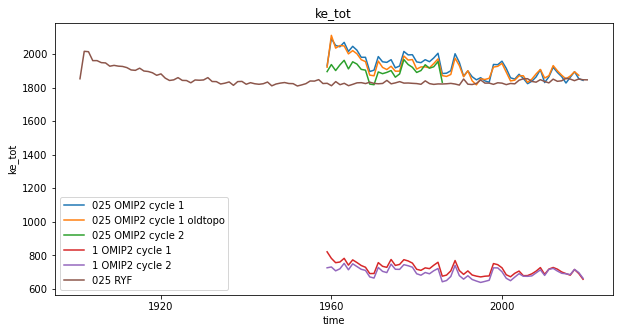

In [15]:
%%time
plot_timeseries('ke_tot',end_time,ncfile='ocean_scalar.nc')

## Area-Averaged Tracer Diagnostics

In [ ]:
def plot_depthintv(variable,end_time,zlims):
    plt.figure(figsize=(10,5))
    for ekey in exptdict.keys():
        expt = exptdict[ekey]['expt']
        print(expt)
        try:
            var = cc.querying.getvar(expt,variable,session,ncfile='ocean.nc',end_time=end_time)
        except:
            var = cc.querying.getvar(expt,variable,session,end_time=end_time)
        varmean = var.sel(st_ocean = slice(zlims[0],zlims[1])).mean('st_ocean').mean('yt_ocean').mean('xt_ocean').resample(time='Y').mean()
        varmean.plot(label=ekey)
    plt.legend()
    plt.title(str(zlims[0]) + ' - ' + str(zlims[1]) + 'm variable')

### Upper 700m temp

In [ ]:
%%time
plot_depthintv('temp',end_time,[0.,700.])

### Upper 2000m temp

In [ ]:
%%time
plot_depthintv('temp',end_time,[0.,2000.])

### 2000m-bottom temp

In [ ]:
%%time
plot_lower_ocean('temp',end_time,[2000.,10000.])

### Plots to make (XXXX):
- Temperature and salinity drifts compared to WOA13

## Circulation Diagnostics

### Drake Passage Transport

025deg_jra55_iaf_cycle1


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


025deg_jra55_iaf_newIC


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


025deg_jra55_iaf_cycle2
1deg_jra55_iaf_omip2


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


1deg_jra55_iaf_omip2_cycle2


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


025deg_jra55_ryf9091_gadi


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


CPU times: user 32.5 s, sys: 1.1 s, total: 33.6 s
Wall time: 1min 17s


Text(0.5, 1.0, 'ACC Transport')

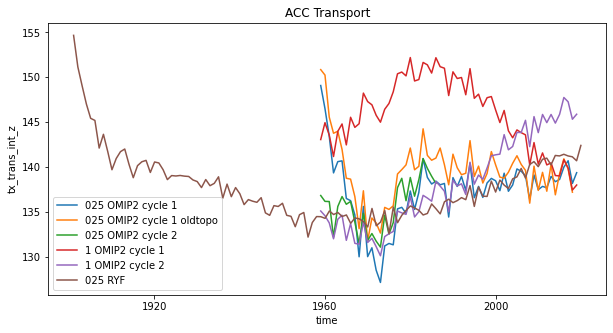

In [16]:
%%time

xmin=-69.9
ymin=-71.6
ymax=-51.0

variable='tx_trans_int_z'
plt.figure(figsize=(10,5))
for ekey in exptdict.keys():
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,variable,session,end_time=end_time)
    DP = var.sel(xu_ocean=xmin, method='nearest').sel(yt_ocean=slice(ymin, ymax)).sum('yt_ocean').resample(time='Y').mean()/1e6/1036
    DP.plot(label=ekey)

plt.legend()
plt.title("ACC Transport")

### AABW overturning circulation @ 55°S

025deg_jra55_iaf_cycle1


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

025deg_jra55_iaf_newIC


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


025deg_jra55_iaf_cycle2
1deg_jra55_iaf_omip2
1deg_jra55_iaf_omip2_cycle2
025deg_jra55_ryf9091_gadi
CPU times: user 3min 15s, sys: 6.15 s, total: 3min 21s
Wall time: 4min 40s


Text(0.5, 1.0, 'AABW Cell')

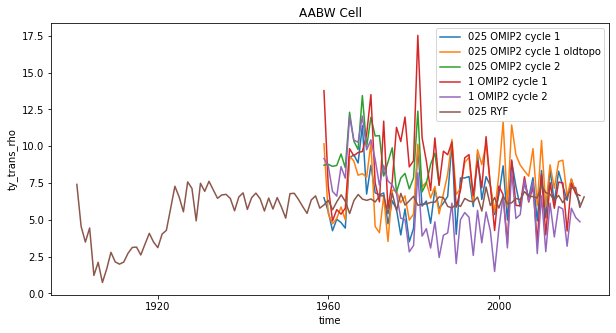

In [17]:
%%time
latitude=-55
plt.figure(figsize=(10,5))
variable='ty_trans_rho'
for ekey in exptdict.keys():
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,variable,session,end_time=end_time)
    psi_aabw = var.sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=latitude)*1.0e-9
    psi_aabw_sum = psi_aabw.cumsum('potrho') - psi_aabw.sum('potrho')
    psi_aabw_sum = -psi_aabw_sum.sel(potrho=slice(1036.2,None)).min('potrho').resample(time='Y').mean()
    psi_aabw_sum.plot(label=ekey)
plt.legend()
plt.title('AABW Cell')

### AMOC Overturning @ 26°N

025deg_jra55_iaf_cycle1
025deg_jra55_iaf_newIC
025deg_jra55_iaf_cycle2
1deg_jra55_iaf_omip2
1deg_jra55_iaf_omip2_cycle2
025deg_jra55_ryf9091_gadi
CPU times: user 1min 54s, sys: 4.39 s, total: 1min 58s
Wall time: 2min 45s


Text(0.5, 1.0, 'AMOC Cell')

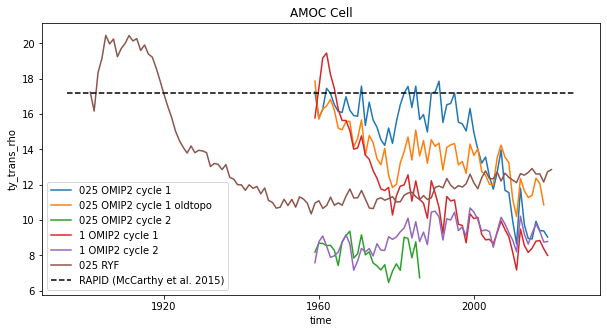

In [6]:
%%time
plt.figure(figsize=(10,5))
variable='ty_trans_rho'
for ekey in exptdict.keys():
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,variable,session,end_time=end_time)
    psi_amoc = var.sel(grid_xt_ocean=slice(-103,-5)).sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=26)*1.0e-9
    psi_amoc_sum = psi_amoc.cumsum('potrho') - psi_amoc.sum('potrho')
    psi_amoc_sum = psi_amoc_sum.sel(potrho=slice(1035.5,None)).max('potrho').resample(time='Y').mean()
    psi_amoc_sum.plot(label=ekey)
xlims = plt.xlim()
plt.plot(xlims,[17.2,17.2],'--k',label='RAPID (McCarthy et al. 2015)')
plt.legend()
plt.title('AMOC Cell')

### Indonesian Throughflow

025deg_jra55_iaf_cycle1
025deg_jra55_iaf_newIC
025deg_jra55_iaf_cycle2
1deg_jra55_iaf_omip2
1deg_jra55_iaf_omip2_cycle2
025deg_jra55_ryf9091_gadi
CPU times: user 29.5 s, sys: 946 ms, total: 30.4 s
Wall time: 50.3 s


Text(0.5, 1.0, 'Indonesian Throughflow (115E)')

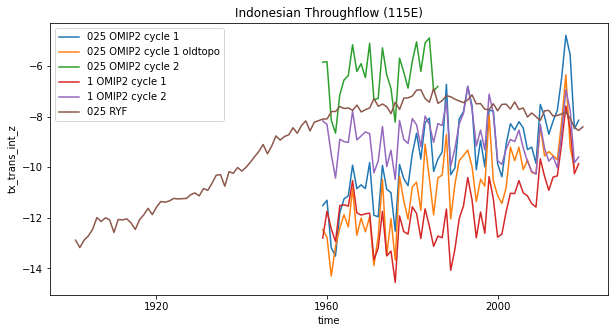

In [29]:
%%time

xmin=115.0-360.
ymin=-22.
ymax=-8.25

variable='tx_trans_int_z'
plt.figure(figsize=(10,5))
for ekey in exptdict.keys():
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,variable,session,end_time=end_time)
    DP = var.sel(xu_ocean=xmin, method='nearest').sel(yt_ocean=slice(ymin, ymax)).sum('yt_ocean').resample(time='Y').mean()/1e6/1036
    DP.plot(label=ekey)

plt.legend()
plt.title("Indonesian Throughflow (115E)")

### Plots to make (XXXX):
- GMOC minimum at 30S.
- Meridional heat transport
- Eastern Pacific zonal velocity
- OHC anomalies + sea level rise - but probably not worth it until last cycle for drift reasons.
- Some sea ice metrics?

## Global Overturning Streamfunction

In [31]:
def plot_psi(psi_avg, clev=np.arange(-25,25,2)):    
    p1 = plt.contourf(psi_avg.grid_yu_ocean, 
                 psi_avg.potrho, 
                 psi_avg, 
                 cmap=cm.cm.delta,levels=clev,extend='both')
    plt.contour(psi_avg.grid_yu_ocean, 
                psi_avg.potrho, 
                psi_avg, levels=clev, colors='k', linewidths=0.25)
    plt.contour(psi_avg.grid_yu_ocean,
                psi_avg.potrho, psi_avg,
                levels=[0.0,], colors='k', linewidths=0.5)
    plt.gca().invert_yaxis()
    
    plt.ylim((1037.5,1034))
    plt.ylabel('Potential Density (kg m$^{-3}$)')
    plt.xlabel('Latitude ($^\circ$N)')
    plt.xlim([-75,85])
    
    return p1

In [ ]:
plt.figure(figsize=(15,10))
variable='ty_trans_rho'
ii=0
keys = ['025 OMIP2 cycle 1','025 OMIP2 cycle 1 oldtopo','1 OMIP2 cycle 1','1 OMIP2 cycle 2','025 RYF']
for ekey in exptdict.keys():
    ii+=1
    plt.subplot(2,2,ii)
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,variable,session,start_time='2010-01-01',end_time=end_time)
    psi = var.mean('time').sum('grid_xt_ocean')*1.0e-9
    psi_avg = psi.cumsum('potrho') -  psi.sum('potrho')
    psi_avg.load()
    p1 = plot_psi(psi_avg)
    plt.title(ekey)

025deg_jra55_iaf_cycle1


### Ice Area (in both hemispheres)

Text(0.5, 1.0, 'Southern Ocean')

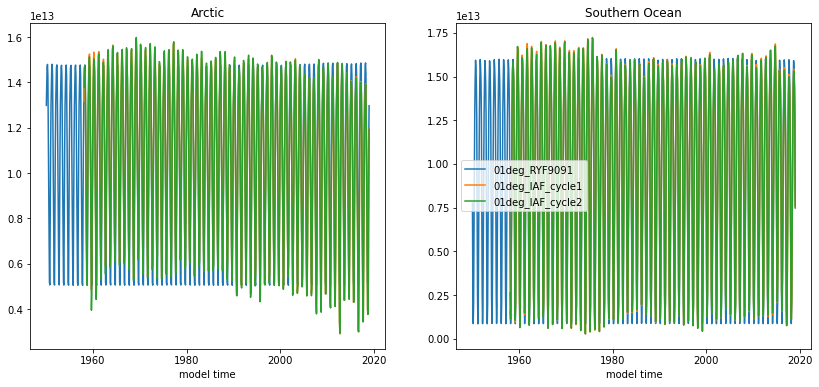

In [13]:
variable='aice_m'
fig,ax = plt.subplots(1,2,figsize=(14,6))
for ekey in exptdict.keys():
    expt = exptdict[ekey]['expt']
    var = cc.querying.getvar(expt,variable,session,start_time='1950-01-01',end_time=end_time,coords="all")
    area_t = cc.querying.getvar(expt, 'area_t',session,n=1)
    var.coords['ni'] = area_t['xt_ocean'].values
    var.coords['nj'] = area_t['yt_ocean'].values
    var = var.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
    area = var*area_t
    area_zonalsum = area.sum('xt_ocean')
    NH_area = area_zonalsum.sel(yt_ocean=slice(45, 90)).sum('yt_ocean').load()
    NH_area.plot(ax=ax[0],label=ekey)
    SH_area = area_zonalsum.sel(yt_ocean=slice(-90, -45)).sum('yt_ocean').load()
    SH_area.plot(ax=ax[1],label=ekey)
plt.legend()
ax[0].set_title('Arctic')
ax[1].set_title('Southern Ocean')

### Ice volume (in both hemispheres)

Text(0.5, 1.0, 'Southern Ocean')

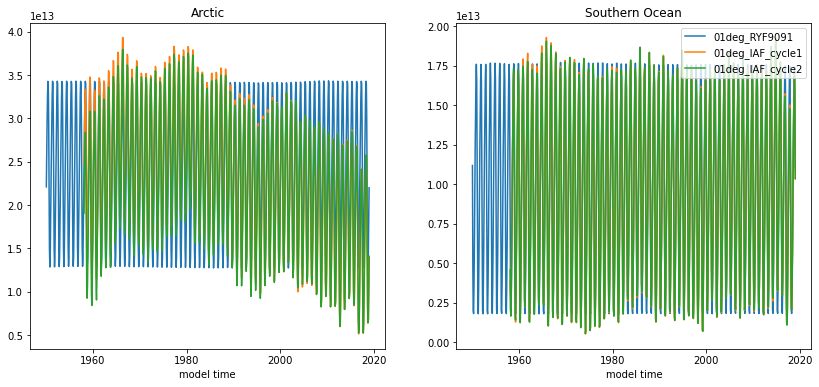

In [14]:
variable='vicen_m'
fig,ax = plt.subplots(1,2,figsize=(14,6))
for ekey in exptdict.keys():
    expt = exptdict[ekey]['expt']
    var = cc.querying.getvar(expt,variable,session,start_time='1950-01-01',end_time=end_time,coords="all")
    area_t = cc.querying.getvar(expt, 'area_t',session,n=1)
    var.coords['ni'] = area_t['xt_ocean'].values
    var.coords['nj'] = area_t['yt_ocean'].values
    var = var.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
    vol = var*area_t
    vol_zonalsum = vol.sum('xt_ocean').sum('nc')
    NH_vol = vol_zonalsum.sel(yt_ocean=slice(45, 90)).sum('yt_ocean').load()
    NH_vol.plot(ax=ax[0],label=ekey)
    SH_vol = vol_zonalsum.sel(yt_ocean=slice(-90, -45)).sum('yt_ocean').load()
    SH_vol.plot(ax=ax[1],label=ekey)
plt.legend()
ax[0].set_title('Arctic')
ax[1].set_title('Southern Ocean')